In [2]:
# 필요한 모듈 import 및 Device 정의
import torchvision.datasets as datasets
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import time
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# MNIST Dataset를 이용하여 CGAN을 학습시킬 예정이다
# MNIST Train Dataset을 다운로드하기 위한 경로변수 정의
path2data = "./data"
os.makedirs(path2data, exist_ok=True) # 만약 존재하면 에러 발생시키지 않고 그냥 진행

# Dataset을 불러올 때 사용하는 Pre-processor정의하기
train_transform = transforms.Compose([
                        transforms.ToTensor(), # 0-1값으로 정규화한 이후, Tensor타입으로 변환
                        transforms.Normalize([0.5],[0.5]), # Standardization
])

# MNIST dataset 불러오기
train_ds = datasets.MNIST(path2data, train=True, transform=train_transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



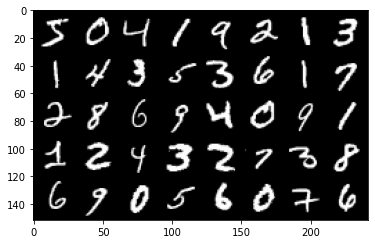

In [7]:
# Sample 이미지를 시각화해보자
img, label = train_ds.data, train_ds.targets

# img의 shape는(60000,28,28)이다
# 채널을 표시하기 위하여 img의 차원을 (60000,1,28,28)으로 변경한다
if len(img.shape) == 3:
  img = img.unsqueeze(1)

# Grid생성하기
# 이미지 여러개를 한꺼번에 표현하는 함수라고 생각하면 된다
# 40개의 batch image를 총 5*8 형태의 grid로 표현하는 것이다.
# 각각의 grid의 사이는 2만큼의 padding으로 채운다
img_grid = utils.make_grid(img[:40], nrow=8, padding=2)

def show(img):
  np_img = img.numpy()
  # matplotlib에서 다루려면 (H,W,C)형태어야 한다
  # 따라서 (C,H,W)를 (H,W,C)로 변경하는 것이다
  np_img_tr = np_img.transpose((1,2,0))
  plt.imshow(np_img_tr)

show(img_grid)

In [8]:
# Dataset을 Batch size만큼 가져오는 DataLoadef을 정의한다
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

In [10]:
# CGAN의 Generator와 Discriminator에서 사용할 Parameters config를 정의한다
params = {'num_classes':10, # 총 클래스 개수
          'nz':100, # noise vector 의 차원
          'input_size':(1,28,28)} # 입력 이미지의 형태

In [12]:
# CGAN의 Generator 구현하기
class Generator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.num_classes = params['num_classes']
    self.nz = params['nz']
    self.input_size = params['input_size']

    # noise와 label을 결합할 용도인 Label Embed Layer를 정의한다
    # 자세한 동작 원리는 Note 정리를 참고한다

    self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

    # Generator의 입력 (batch_size, 110)
    self.gen = nn.Sequential(
        nn.Linear(self.nz + self.num_classes, 128), # output : (batch_size, 128)
        nn.LeakyReLU(0.2),
        nn.Linear(128,256), # output : (batch_size, 256)
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,512), # output : (batch_size, 512)
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024), # output : (batch_size, 1024)
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, int(np.prod(self.input_size))), # output : (batch_size, 784)
        nn.Tanh()
    )

  def forward(self, noise, labels):
    # noise vector와 Embed Label을 결합한다
    gen_input = torch.cat((self.label_emb(labels), noise),-1)
    x = self.gen(gen_input)
    x = x.view(x.size(0), *self.input_size)
    return x # 최종 출력 형태는 (batch_size, 1, 28, 28) 형태이다

# Test Input을 넣어서 확인해보자
x = torch.randn(16,100, device=device) # 16개의 Noise vector
label = torch.randint(0,10,(16,), device=device) # 16개의 label
model_gen = Generator(params).to(device)
out_gen = model_gen(x, label)
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


In [16]:
# Discriminator를 구현하기
class Discriminator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.input_size = params['input_size']
    self.num_classes = params['num_classes']
    self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)

    # input 데이터의 형상은 (batch_size, 784+10)이다
    self.dis = nn.Sequential(
        nn.Linear(self.num_classes+int(np.prod(self.input_size)),512), # output : (batch_size, 512)
        nn.LeakyReLU(0.2),
        nn.Linear(512,512), # output : (batch_size, 512)
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2),
        nn.Linear(512,512), # output : (batch_size, 512)
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1), # output : (batch_size, 1) = batch_size별 실제 이미지일 확률
        nn.Sigmoid()
    )
  
  def forward(self, img, labels):
    dis_input = torch.cat((img.view(img.size(0),-1), self.label_embedding(labels)),-1)
    x = self.dis(dis_input)
    return x

# test input을 넣어서 체크해보자
x = torch.randn(16,1,28,28, device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x, label)
print(out_dis.shape)

torch.Size([16, 1])


In [17]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [18]:
# 손실 함수 및 학습을 위한 파라미터를 정의한다
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4


# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr)
opt_gen = optim.Adam(model_gen.parameters(), lr=lr)

# 학습 파라미터
nz = params['nz']
num_epochs = 100

loss_history={'gen':[],
              'dis':[]}

In [19]:
# 본격적으로 Generator와 Discriminator의 학습을 시행한다
batch_count = 0
start_time = time.time()
model_dis.train() # Discriminator를 train mode로 설정하기
model_gen.train() # Generator를 train mode로 설정하기

for epoch in range(num_epochs): # 총 100 Epoch의 훈련 시작
    for xb, yb in train_dl:
        ba_si = xb.shape[0]     # batch_size

        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device) # fake_label

        # Genetator의 학습과정
        model_gen.zero_grad()
        noise = torch.randn(ba_si,100).to(device) # noise vector생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

        # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real) # Discriminator가 이 모든 사진을 1로 판단하도록 훈련시키는 과정이다
        loss_gen.backward()
        opt_gen.step()

        # Discriminator의 학습과정
        model_dis.zero_grad()
        
        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real) # 실제 이미지를 1로 판단하도록

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label) 
        loss_fake = loss_func(out_dis,yb_fake) # 가짜 이미지를 가짜로 판단하도록

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 5.627431, D_Loss: 0.040796, time: 0.32 min
Epoch: 2, G_Loss: 9.852475, D_Loss: 0.142552, time: 0.65 min
Epoch: 3, G_Loss: 9.698312, D_Loss: 0.009613, time: 0.96 min
Epoch: 4, G_Loss: 2.985541, D_Loss: 0.157469, time: 1.28 min
Epoch: 5, G_Loss: 4.095041, D_Loss: 0.077938, time: 1.59 min
Epoch: 6, G_Loss: 2.221132, D_Loss: 0.280547, time: 1.90 min
Epoch: 7, G_Loss: 3.366451, D_Loss: 0.059322, time: 2.21 min
Epoch: 8, G_Loss: 2.677094, D_Loss: 0.242082, time: 2.53 min
Epoch: 9, G_Loss: 3.930181, D_Loss: 0.062231, time: 2.83 min
Epoch: 10, G_Loss: 4.784417, D_Loss: 0.139856, time: 3.15 min
Epoch: 11, G_Loss: 2.639779, D_Loss: 0.109642, time: 3.46 min
Epoch: 12, G_Loss: 2.443296, D_Loss: 0.178766, time: 3.77 min
Epoch: 13, G_Loss: 2.545782, D_Loss: 0.220919, time: 4.08 min
Epoch: 14, G_Loss: 1.909262, D_Loss: 0.217701, time: 4.39 min
Epoch: 15, G_Loss: 2.868439, D_Loss: 0.081993, time: 4.71 min
Epoch: 17, G_Loss: 2.341052, D_Loss: 0.334885, time: 5.02 min
Epoch: 18, G_Loss

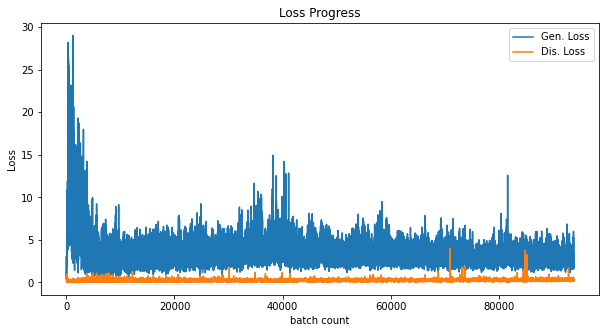

In [20]:
# Batch 데이터별 loss를 시각화 한다
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# 현재 모델의 가중치를 저장한다
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [24]:
# 가중치를 불러와서 Generator가 생성한 가짜 이미지를 확인해보자
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise, label).detach().cpu()
print(img_fake.shape)
print(label)

torch.Size([16, 1, 28, 28])
tensor([3, 1, 5, 5, 7, 9, 9, 0, 5, 6, 8, 5, 9, 2, 3, 9], device='cuda:0')


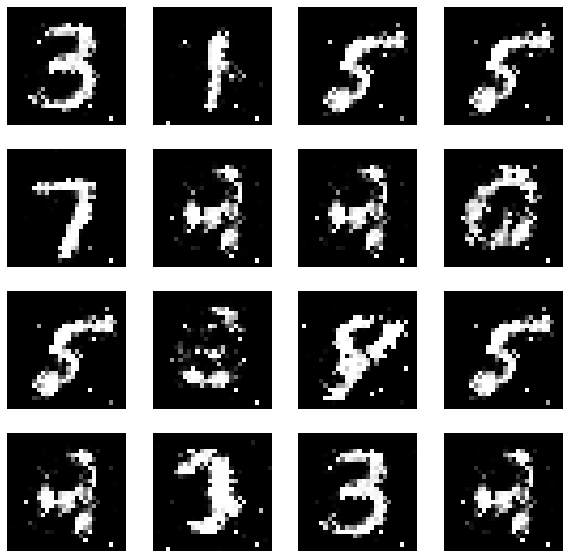

In [25]:
# 가짜 이미지 시각화
# label과 매우 비슷한 이미지들이 성공적으로 생성되었다
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')